In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import scipy.stats as st
import statsmodels.api as sm

In [2]:
df=pd.read_csv("C:/Users/prash/Pictures/Group 4_ForestCoverType/covtype.csv")
df.columns=['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
                        'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
                        'Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
                        'Horizontal_Distance_To_Fire_Points','Rawah_Wilderness_Area','Neota_Wilderness_Area',
            'Comanche_Peak_Wilderness_Area','Cache_la_Poudre_Wilderness_Area',"Soil_code_2702",
                        "Soil_code_2703","Soil_code_2704","Soil_code_2705","Soil_code_2706","Soil_code_2717",
                        "Soil_code_3501","Soil_code_3502","Soil_code_4201","Soil_code_4703","Soil_code_4704",
                        "Soil_code_4744","Soil_code_4758","Soil_code_5101","Soil_code_5151","Soil_code_6101",
                        "Soil_code_6102","Soil_code_6731","Soil_code_7101","Soil_code_7102","Soil_code_7103",
                        "Soil_code_7201","Soil_code_7202","Soil_code_7700","Soil_code_7701","Soil_code_7702",
                        "Soil_code_7709","Soil_code_7710","Soil_code_7745","Soil_code_7746","Soil_code_7755",
                        "Soil_code_7756","Soil_code_7757","Soil_code_7790","Soil_code_8703","Soil_code_8707",
                        "Soil_code_8708","Soil_code_8771","Soil_code_8772","Soil_code_8776",'Cover_Type']

In [3]:
df['Distance_To_Hydrology']=np.round(np.sqrt(df['Horizontal_Distance_To_Hydrology']**2+
                                             df['Vertical_Distance_To_Hydrology']**2),2)
df['Hillshade']=np.round((df['Hillshade_9am']+df['Hillshade_Noon']+
                                  df['Hillshade_3pm'])/3,2)
df.drop(['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
          'Hillshade_9am','Hillshade_Noon','Hillshade_3pm'], axis=1, inplace=True)

In [4]:
#Creating CG Zones
soil=['Soil_code_2702', 'Soil_code_2703',
       'Soil_code_2704', 'Soil_code_2705', 'Soil_code_2706', 'Soil_code_2717',
       'Soil_code_3501', 'Soil_code_3502', 'Soil_code_4201', 'Soil_code_4703',
       'Soil_code_4704', 'Soil_code_4744', 'Soil_code_4758', 'Soil_code_5101',
       'Soil_code_5151', 'Soil_code_6101', 'Soil_code_6102', 'Soil_code_6731',
       'Soil_code_7101', 'Soil_code_7102', 'Soil_code_7103', 'Soil_code_7201',
       'Soil_code_7202', 'Soil_code_7700', 'Soil_code_7701', 'Soil_code_7702',
       'Soil_code_7709', 'Soil_code_7710', 'Soil_code_7745', 'Soil_code_7746',
       'Soil_code_7755', 'Soil_code_7756', 'Soil_code_7757', 'Soil_code_7790',
       'Soil_code_8703', 'Soil_code_8707', 'Soil_code_8708', 'Soil_code_8771',
       'Soil_code_8772', 'Soil_code_8776']
df['cgzone']=df[soil].idxmax(axis=1) # reconstrucing the Dummies
def cg(x):
    if x[-4:-2]=='27':
        return 'cgzone_27'
    if x[-4:-2]=='35':
        return 'cgzone_35'
    if x[-4:-2]=='42':
        return 'cgzone_42'
    if x[-4:-2]=='47':
        return 'cgzone_47'
    if x[-4:-2]=='51':
        return 'cgzone_51'
    if x[-4:-2]=='61':
        return 'cgzone_61'
    if x[-4:-2]=='67':
        return 'cgzone_67'
    if x[-4:-2]=='71':
        return 'cgzone_71'
    if x[-4:-2]=='72':
        return 'cgzone_72'
    if x[-4:-2]=='77':
        return 'cgzone_77'
    if x[-4:-2]=='87':
        return 'cgzone_87'
df['cgzone']=df['cgzone'].apply(lambda x:cg(x))
dummies = pd.get_dummies(df['cgzone']) # Converting CG to Dummies

df=pd.concat((df,dummies), axis=1)
df.drop('cgzone', axis=1, inplace=True)
df.drop(soil,axis=1, inplace=True) # Dropping the Soil 40 Soil Types

In [5]:
numeric=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points',
       'Distance_To_Hydrology', 'Hillshade']

In [6]:
#### Capping the outliers
# Defining an function for Capping
def cap(x):
    if x<ll:
        return ll
    elif x>ul:
        return ul
    else:
        return x
    
for i in numeric:
    ul=df[i].mean()+(3*df[i].std())
    ll=df[i].mean()-(3*df[i].std())
    df[i]=df[i].apply(lambda x:cap(x))

In [7]:
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

In [8]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Rawah_Wilderness_Area,Neota_Wilderness_Area,Comanche_Peak_Wilderness_Area,Cache_la_Poudre_Wilderness_Area,Cover_Type,Distance_To_Hydrology,Hillshade,cgzone_27,cgzone_35,cgzone_42,cgzone_47,cgzone_51,cgzone_61,cgzone_67,cgzone_71,cgzone_72,cgzone_77,cgzone_87
0,2590.0,56,2.0,390.0,5952.836848,1,0,0,0,5,212.08,202.00,0,0,0,0,0,0,0,0,0,1,0
1,2804.0,139,9.0,3180.0,5952.836848,1,0,0,0,2,275.77,202.33,0,0,0,1,0,0,0,0,0,0,0
2,2785.0,155,18.0,3090.0,5952.836848,1,0,0,0,2,269.24,199.33,0,0,0,0,0,0,0,0,0,1,0
3,2595.0,45,2.0,391.0,5952.836848,1,0,0,0,5,153.00,201.33,0,0,0,0,0,0,0,0,0,1,0
4,2579.0,132,6.0,67.0,5952.836848,1,0,0,0,2,300.37,202.33,0,0,0,0,0,0,0,0,0,1,0


In [9]:
df.shape

(581011, 23)

In [10]:
numeric=['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points',
       'Distance_To_Hydrology', 'Hillshade']

# Before Statification of Split

In [11]:
from sklearn.model_selection import train_test_split
X=df.drop('Cover_Type',1)
y=df['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# dd=pd.concat([X_working,y_working],axis=1)
pd.concat([df['Cover_Type'].value_counts(normalize=True).mul(100),y_train.value_counts(normalize=True).mul(100)
          ,y_test.value_counts(normalize=True).mul(100)],axis=1, keys=['Population','Train','Test'])

,Population,Train,Test
2,48.760006,48.747378,48.789471
1,36.460583,36.444172,36.498876
3,6.153756,6.162176,6.134111
7,3.530054,3.550468,3.482422
6,2.989100,2.991343,2.983867
5,1.633704,1.630412,1.641385
4,0.472797,0.474051,0.469869


# After Statification of split

In [33]:
from sklearn.model_selection import train_test_split
X=df.drop('Cover_Type',1)
y=df['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,
                                                            stratify=df['Cover_Type'])
# dd=pd.concat([X_working,y_working],axis=1)
pd.concat([df['Cover_Type'].value_counts(normalize=True).mul(100),y_train.value_counts(normalize=True).mul(100)
          ,y_test.value_counts(normalize=True).mul(100)],axis=1, keys=['Population','Train','Test'])

,Population,Train,Test
2,48.760006,48.759918,48.760212
1,36.460583,36.460646,36.460437
3,6.153756,6.153816,6.153617
7,3.530054,3.530060,3.530039
6,2.989100,2.989130,2.989031
5,1.633704,1.633608,1.633927
4,0.472797,0.472822,0.472737


# Feature Sellection

## Based on Chi2 (Univariate selection)

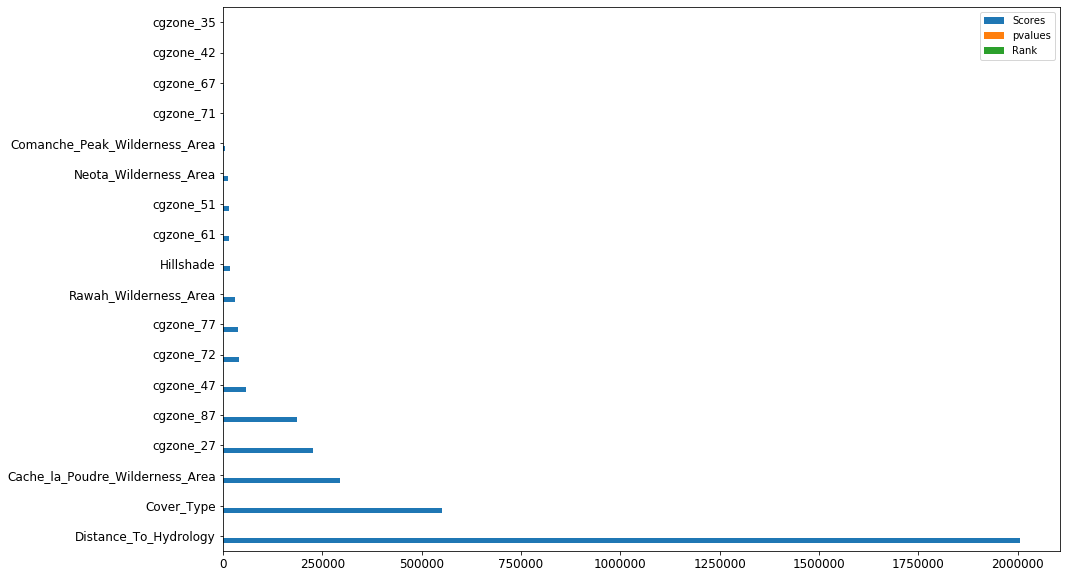

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X=df[df.columns[5:49]]
Y=df['Cover_Type']
test = SelectKBest(score_func=chi2, k='all')
fit = test.fit(X, Y)
scoreschi2=pd.DataFrame(index=X.columns)
scoreschi2['Scores']=fit.scores_ 
scoreschi2['pvalues']=fit.pvalues_
scoreschi2['Rank']=scoreschi2['Scores'].rank(method='dense',ascending=False )
scoreschi2=scoreschi2.sort_values(by='Rank')
scoreschi2.plot(kind='barh', figsize=(15, 10), legend=True, fontsize=12)
scoreschi2['Scores']=scoreschi2['Scores'].apply(lambda x
                                                : (x/scoreschi2['Scores'].sum()))

In [14]:
scoreschi2

,Scores,pvalues,Rank
Distance_To_Hydrology,0.572651,0.000000e+00,1.0
Cover_Type,0.157639,0.000000e+00,2.0
Cache_la_Poudre_Wilderness_Area,0.084169,0.000000e+00,3.0
cgzone_27,0.064864,0.000000e+00,4.0
cgzone_87,0.053092,0.000000e+00,5.0
cgzone_47,0.016792,0.000000e+00,6.0
cgzone_72,0.011581,0.000000e+00,7.0
cgzone_77,0.010936,0.000000e+00,8.0
Rawah_Wilderness_Area,0.008847,0.000000e+00,9.0
Hillshade,0.005117,0.000000e+00,10.0


## Based on Anova (Univariate selection)

,Scores,pvalues,Rank
Elevation,0.833152,0.0,1.0
Horizontal_Distance_To_Roadways,0.055159,0.0,2.0
Slope,0.041718,0.0,3.0
Horizontal_Distance_To_Fire_Points,0.039749,0.0,4.0
Hillshade,0.016593,0.0,5.0
Distance_To_Hydrology,0.011230,0.0,6.0
Aspect,0.002398,0.0,7.0


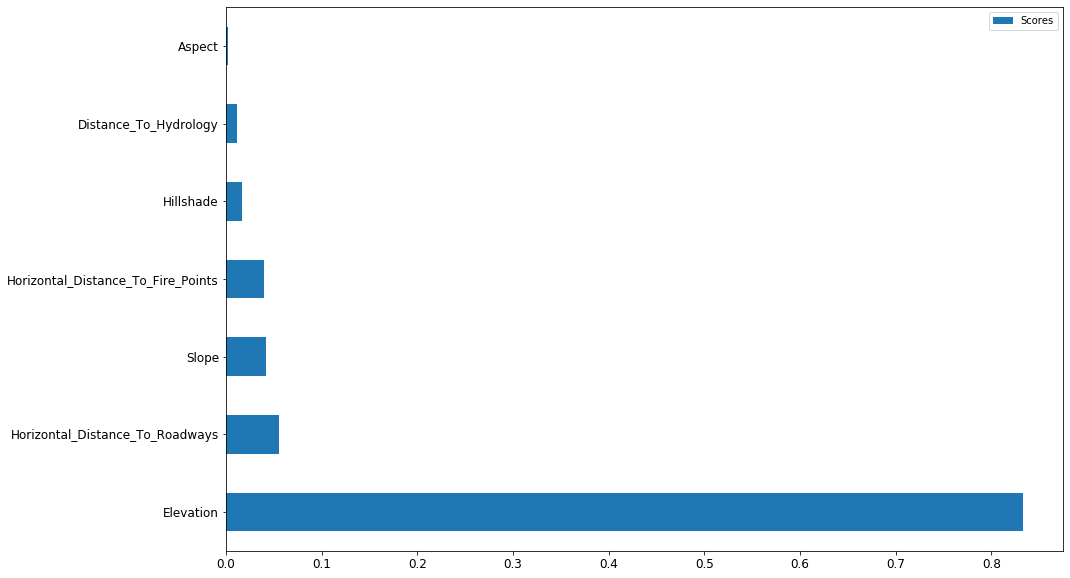

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X=df[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points',
     'Distance_To_Hydrology', 'Hillshade']]
Y=df['Cover_Type']
test = SelectKBest(score_func=f_classif, k='all')
fit = test.fit(X, Y)
anova=pd.DataFrame(index=X.columns)
anova['Scores']=fit.scores_ 
anova['pvalues']=fit.pvalues_
anova['Rank']=anova['Scores'].rank(method='dense',ascending=False )
anova=anova.sort_values(by='Rank')
anova['Scores']=anova['Scores'].apply(lambda x: (x/anova['Scores'].sum()))
anova['Scores'].plot(kind='barh', figsize=(15, 10), legend=True, fontsize=12)
anova

## BASED ON MUTUAL (UNIVARIATE SELLECTION)

,Scores,Rank
Elevation,0.457645,1.0
Cache_la_Poudre_Wilderness_Area,0.145352,2.0
cgzone_27,0.110391,3.0
cgzone_77,0.101091,4.0
cgzone_87,0.097416,5.0
Horizontal_Distance_To_Roadways,0.088861,6.0
Rawah_Wilderness_Area,0.080473,7.0
Horizontal_Distance_To_Fire_Points,0.068790,8.0
cgzone_47,0.066796,9.0
Distance_To_Hydrology,0.056931,10.0


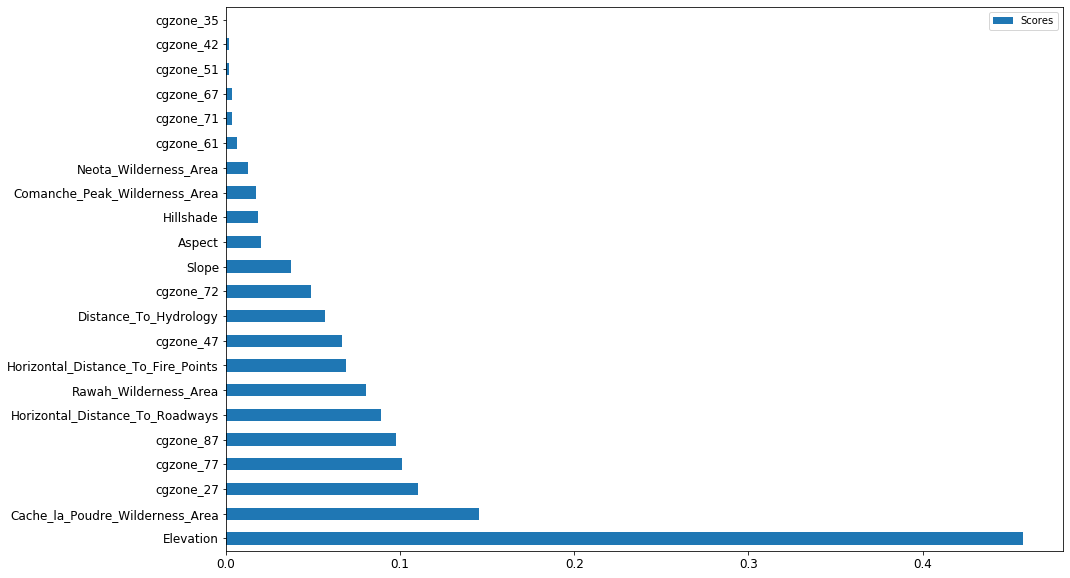

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
X=df.drop('Cover_Type',axis=1)
Y=df['Cover_Type']
test = SelectKBest(score_func=mutual_info_classif, k='all')
fit = test.fit(X, Y)
mutual=pd.DataFrame(index=X.columns)
mutual['Scores']=fit.scores_ 
mutual['Rank']=mutual['Scores'].rank(method='dense',ascending=False )
mutual=mutual.sort_values(by='Rank')
mutual['Scores'].plot(kind='barh', figsize=(15, 10), legend=True, fontsize=12)
mutual

## Recursive Feature Elimination

In [14]:
# #LogisticRegression
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# X=df.drop('Cover_Type',1)
# Y=df['Cover_Type']
# #Feature extraction
# model = LogisticRegression() 
# rfe = RFE(model, 1)
# fit = rfe.fit(X, Y)
# print("Num Features: %d"% fit.n_features_) 
# print("Selected Features: %s"% fit.support_) 
# print("Feature Ranking: %s"% fit.ranking_)

Num Features: 1
Selected Features: [False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
Feature Ranking: [ 5  4  1  7  6  9 16 14  8 31 23 30 19 34 27 49 50 39 13 26 15 21 44 51
 43 32 41 36 38 40 10 11 28 47 35 46 42 12 20 29 22 25 37 33 48 45 17 18
 24  3  2]


In [19]:
# refsum=pd.DataFrame(data=fit.ranking_,index=X.columns)
# refsum=refsum.sort_values(by=0)
# refsum

,0
Slope,1
Hillshade,2
Distance_To_Hydrology,3
Aspect,4
Elevation,5
Horizontal_Distance_To_Fire_Points,6
Horizontal_Distance_To_Roadways,7
Cache_la_Poudre_Wilderness_Area,8
Rawah_Wilderness_Area,9
Soil_code_7201,10


# Balancing Using SMOTE

In [34]:
sm = SMOTE(random_state=42)
X_res, y_res = X_train, y_train 
X_train, y_train = sm.fit_resample(X_res, y_res)
X_train=pd.DataFrame(X_train,columns=df.drop('Cover_Type',axis=1).columns)

In [35]:
print('X_train.shape',X_train.shape)
print('y_train.shape',y_train.shape)

X_train.shape (1388170, 22)
y_train.shape (1388170,)


# Logistic Regression

In [20]:
# install in anaconda prompt
# conda install -c conda-forge imbalanced-learn

In [30]:
LRestim=LogisticRegression(random_state=42,multi_class='multinomial',solver='saga',class_weight='balanced')
LRparam={'C':[1.0,0.1,0.001]}
LRCV=RandomizedSearchCV(estimator=LRestim,param_distributions=LRparam
                        ,n_jobs=-1,cv=5,random_state=42)
best_parameter_search = LRCV.fit(X_train, y_train)
best_parameter_search.best_params_

{'C': 0.1}

In [31]:
pd.DataFrame(best_parameter_search.cv_results_)[['mean_test_score','params']]

,mean_test_score,params
0,0.541872,{'C': 1.0}
1,0.541872,{'C': 0.1}
2,0.541832,{'C': 0.001}


In [18]:
#Chosen the Best paramerts given
LR = LogisticRegression(C=1,class_weight='balanced',solver='saga',
                        random_state=42,multi_class='multinomial')
LR.fit(X_train,y_train)
y_pred_LR = LR.predict(X_test)
trainLR=LR.predict(X_train)
cm= confusion_matrix(y_test,y_pred_LR)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['Recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                  (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                  (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                  (cm[6][6]/a['sum'][7])*100),2))
print('Train Recall',recall_score(y_train, trainLR, average='weighted'))
print('Test Recall',recall_score(y_test,y_pred_LR, average='weighted'))
print(a['Recall'])

Train Recall 0.5487339446897714
Test Recall 0.45861253901230037
1    50.49
2    40.44
3    39.42
4    68.57
5    61.97
6    36.62
7    81.50
Name: Recall, dtype: float64


# Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=42,class_weight='balanced')
tree_param = {"criterion":["gini", "entropy"],
    "splitter":["best", "random"],
    "max_depth":[14,16,18,20,22,25,30,35],
    "max_features":["auto","sqrt","log2"],}
grid = RandomizedSearchCV(estimator=tree, param_distributions=tree_param,
                          cv = 5,random_state=42)
best_parameter_search_DT = grid.fit(X_train, y_train)
best_parameter_search_DT.best_params_

{'splitter': 'best',
 'max_features': 'log2',
 'max_depth': 35,
 'criterion': 'entropy'}

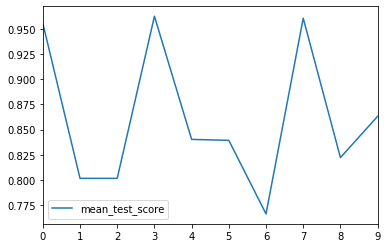

In [34]:
pd.DataFrame(best_parameter_search_DT.cv_results_)[['mean_test_score']].plot()

In [35]:
pd.DataFrame(best_parameter_search_DT.cv_results_)[['mean_test_score','param_max_depth','params']]

,mean_test_score,param_max_depth,params
0,0.955356,25,"{'splitter': 'best', 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'entropy'}"
1,0.801611,22,"{'splitter': 'random', 'max_features': 'log2', 'max_depth': 22, 'criterion': 'entropy'}"
2,0.801611,22,"{'splitter': 'random', 'max_features': 'auto', 'max_depth': 22, 'criterion': 'entropy'}"
3,0.962359,35,"{'splitter': 'best', 'max_features': 'log2', 'max_depth': 35, 'criterion': 'entropy'}"
4,0.840253,25,"{'splitter': 'random', 'max_features': 'sqrt', 'max_depth': 25, 'criterion': 'gini'}"
5,0.839297,25,"{'splitter': 'random', 'max_features': 'auto', 'max_depth': 25, 'criterion': 'entropy'}"
6,0.766352,20,"{'splitter': 'random', 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'entropy'}"
7,0.960400,35,"{'splitter': 'best', 'max_features': 'auto', 'max_depth': 35, 'criterion': 'gini'}"
8,0.822210,14,"{'splitter': 'best', 'max_features': 'auto', 'max_depth': 14, 'criterion': 'gini'}"
9,0.863131,16,"{'splitter': 'best', 'max_features': 'log2', 'max_depth': 16, 'criterion': 'gini'}"


In [19]:
#Based on the above table best features manually  sellected
DT=DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=25,
                          max_features='sqrt',random_state=42,class_weight='balanced')
DT.fit(X_train,y_train)
DTpred=DT.predict(X_test)
trainDT=DT.predict(X_train)
cm= confusion_matrix(y_test,DTpred)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
print('Train Recall',recall_score(y_train, trainDT, average='weighted'))
print('Test Recall',recall_score(y_test,DTpred, average='weighted'))
a['recall']

Train Recall 0.987796163294121
Test Recall 0.8868815402974114


1    88.48
2    89.04
3    88.81
4    80.95
5    82.51
6    84.30
7    93.39
Name: recall, dtype: float64

In [20]:
DT=DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=35,
                          max_features='log2',random_state=42,class_weight='balanced')
DT.fit(X_train,y_train)
DTpred=DT.predict(X_test)
trainDT=DT.predict(X_train)
cm= confusion_matrix(y_test,DTpred)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
print('Train Recall',recall_score(y_train, trainDT, average='weighted'))
print('Test Recall',recall_score(y_test,DTpred, average='weighted'))
a['recall']

Train Recall 0.9998127030551013
Test Recall 0.8982180558105379


1    89.95
2    90.37
3    89.18
4    81.67
5    80.06
6    82.30
7    93.97
Name: recall, dtype: float64

In [21]:
DT=DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=35,
                          max_features='auto',random_state=42,class_weight='balanced')
DT.fit(X_train,y_train)
DTpred=DT.predict(X_test)
trainDT=DT.predict(X_train)
cm= confusion_matrix(y_test,DTpred)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
print('Train Recall',recall_score(y_train, trainDT, average='weighted'))
print('Test Recall',recall_score(y_test,DTpred, average='weighted'))
a['recall']

Train Recall 0.9987868920953485
Test Recall 0.8919818248577198


1    89.03
2    89.74
3    89.18
4    83.01
5    81.53
6    83.01
7    93.09
Name: recall, dtype: float64

# Random Forest

In [22]:
rf = RandomForestClassifier(n_jobs=-1,random_state=42)
rf.fit(X_train,y_train)
rfpred=rf.predict(X_test)
trainRF=rf.predict(X_train)
cm= confusion_matrix(y_test,rfpred)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
print('Train Recall',recall_score(y_train, trainRF, average='weighted'))
print('Test Recall',recall_score(y_test,rfpred, average='weighted'))
print(a['recall'])

Train Recall 1.0
Test Recall 0.9543269230769231
1    94.86
2    96.12
3    95.80
4    90.66
5    89.40
6    92.78
7    96.86
Name: recall, dtype: float64


In [28]:
# After Feature Sellection
Percent =[]
Features=[]
Total_Recall_Train=[]
Total_Recall_Test=[]
Min_Recall_Test=[]
IndRecall=pd.DataFrame(index=[1,2,3,4,5,6,7])
X_train=pd.DataFrame(data=X_train,columns=df.drop('Cover_Type',axis=1).columns)
from sklearn.ensemble import RandomForestClassifier
for i in ['.01','.02','0.03','0.04','0.05']:
    Percent.append(i)
    rf = RandomForestClassifier(n_jobs=-1, random_state=42)
    rf.fit(X_train,y_train)
    feat_imp_RF = rf.feature_importances_
    colsrf = df.drop('Cover_Type',axis=1).columns[feat_imp_RF >= np.float(i)]
    Features.append(len(colsrf))
    rf_imp = RandomForestClassifier(n_jobs=-1, random_state=42)
    rf_imp=rf_imp.fit(X_train[colsrf], y_train)
    rfpred_imp=rf_imp.predict(X_test[colsrf])
    cm= confusion_matrix(y_test,rfpred_imp)
    a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
    a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
    a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
    trainRF_imp=rf_imp.predict(X_train[colsrf])
    Total_Recall_Train.append(recall_score(y_train, trainRF_imp, average='weighted'))
    Total_Recall_Test.append(recall_score(y_test,rfpred_imp, average='weighted'))
    Min_Recall_Test.append(a['recall'].min())
    IndRecall[i]=a['recall']

In [29]:
summaryRF= pd.DataFrame({'Percent':Percent,'Features':Features,
                      'Total_Recall_Train':Total_Recall_Train,
                         'Total_Recall_Test':Total_Recall_Test,'Min_Recall_Test':Min_Recall_Test})
print(summaryRF)
print(IndRecall)

  Percent  Features  Total_Recall_Train  Total_Recall_Test  Min_Recall_Test
0     .01        15                 1.0           0.955015            89.71
1     .02        13                 1.0           0.956358            89.54
2    0.03        11                 1.0           0.951355            89.85
3    0.04         9                 1.0           0.952939            89.68
4    0.05         6                 1.0           0.951940            90.31
     .01    .02   0.03   0.04   0.05
1  94.94  95.20  94.92  95.01  95.23
2  96.17  96.23  95.44  95.68  95.45
3  95.85  95.94  95.88  95.65  94.94
4  91.38  91.26  91.26  91.14  91.75
5  89.71  89.54  89.85  89.68  90.31
6  92.86  93.15  92.86  93.45  92.46
7  96.96  97.01  96.85  96.93  96.80


# RandomForest hyperparameter with (95% Variance)

In [41]:
RFtree = RandomForestClassifier(n_jobs=-1,random_state=42,class_weight='balanced',max_depth=25)
RFtree_param = {"criterion":["gini", "entropy"],'n_estimators':[50,100,150,200]}
RFgrid = RandomizedSearchCV(estimator=RFtree, param_distributions=RFtree_param,
                          cv = 5,random_state=42)
best_parameter_search_RF = RFgrid.fit(X_train[colsrf], y_train)
best_parameter_search_RF.best_params_

{'n_estimators': 200, 'criterion': 'entropy'}

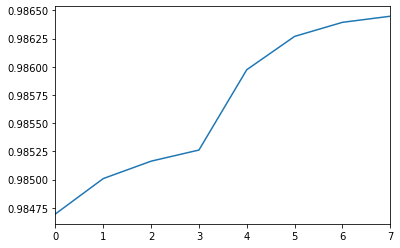

,mean_test_score,param_n_estimators,params
0,0.984696,50,"{'n_estimators': 50, 'criterion': 'gini'}"
1,0.985009,100,"{'n_estimators': 100, 'criterion': 'gini'}"
2,0.985163,150,"{'n_estimators': 150, 'criterion': 'gini'}"
3,0.985262,200,"{'n_estimators': 200, 'criterion': 'gini'}"
4,0.985974,50,"{'n_estimators': 50, 'criterion': 'entropy'}"
5,0.986269,100,"{'n_estimators': 100, 'criterion': 'entropy'}"
6,0.986394,150,"{'n_estimators': 150, 'criterion': 'entropy'}"
7,0.986448,200,"{'n_estimators': 200, 'criterion': 'entropy'}"


In [42]:
pd.DataFrame(best_parameter_search_RF.cv_results_)['mean_test_score'].plot()
plt.show()
pd.DataFrame(best_parameter_search_RF.cv_results_)[['mean_test_score','param_n_estimators','params']]

In [36]:
X_train=pd.DataFrame(data=X_train,columns=X.columns)
rf = RandomForestClassifier(n_jobs=-1,criterion='entropy',n_estimators=50,random_state=42,
                            class_weight='balanced',max_depth=25)
rf.fit(X_train[colsrf],y_train)
rfpred=rf.predict(X_test[colsrf])
trainRF=rf.predict(X_train[colsrf])
cm= confusion_matrix(y_test,rfpred)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
print('Train Recall',recall_score(y_train, trainRF, average='weighted'))
print('Test Recall',recall_score(y_test,rfpred, average='weighted'))
print(a['recall'])

Train Recall 0.9997673195646066
Test Recall 0.9503396364971544
1    95.00
2    95.27
3    94.81
4    91.87
5    91.36
6    92.48
7    96.90
Name: recall, dtype: float64


In [37]:
print('The required Columns are:',colsrf)

The required Columns are: Index(['Elevation', 'Aspect', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points', 'Distance_To_Hydrology',
       'cgzone_87'],
      dtype='object')


# Naive Bayes

In [38]:
from  sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB=NB.fit(X_train,y_train)
NBpred=NB.predict(X_test)
cm= confusion_matrix(y_test,NBpred)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
trainNB=NB.predict(X_train)
print('Train Recall',recall_score(y_train, trainNB, average='weighted'))
print('Test Recall',recall_score(y_test,NBpred, average='weighted'))
print(a['recall'])

Train Recall 0.31509901525029355
Test Recall 0.2622429777859372
1    25.52
2    24.44
3    49.50
4    49.88
5    35.08
6    12.50
7    21.91
Name: recall, dtype: float64


In [12]:
#Navie Bayes Feature enginered (Not Required Low Recall)

# KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_param = {"n_neighbors":[3,4,5,6,7,8],
    "p":[1,2],
    "leaf_size":[30,40,50]}
knncv = RandomizedSearchCV(estimator=knn, param_distributions=knn_param,
                          cv = 5,random_state=42)
best_parameter_search_knn = knncv.fit(X_train, y_train)
best_parameter_search_knn.best_params_

{'p': 1, 'n_neighbors': 3, 'leaf_size': 40}

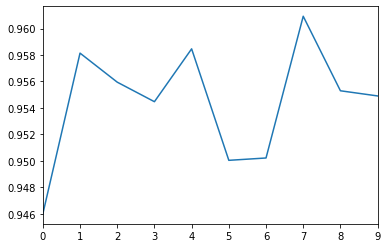

,mean_test_score,param_n_neighbors,params
0,0.945981,8,"{'p': 2, 'n_neighbors': 8, 'leaf_size': 50}"
1,0.958139,3,"{'p': 2, 'n_neighbors': 3, 'leaf_size': 40}"
2,0.955944,4,"{'p': 1, 'n_neighbors': 4, 'leaf_size': 50}"
3,0.954466,6,"{'p': 1, 'n_neighbors': 6, 'leaf_size': 50}"
4,0.958461,5,"{'p': 1, 'n_neighbors': 5, 'leaf_size': 40}"
5,0.950033,6,"{'p': 2, 'n_neighbors': 6, 'leaf_size': 50}"
6,0.950210,7,"{'p': 2, 'n_neighbors': 7, 'leaf_size': 40}"
7,0.960928,3,"{'p': 1, 'n_neighbors': 3, 'leaf_size': 40}"
8,0.955292,7,"{'p': 1, 'n_neighbors': 7, 'leaf_size': 30}"
9,0.954901,5,"{'p': 2, 'n_neighbors': 5, 'leaf_size': 40}"


In [14]:
pd.DataFrame(best_parameter_search_knn.cv_results_)['mean_test_score'].plot()
plt.show()
pd.DataFrame(best_parameter_search_knn.cv_results_)[['mean_test_score','param_n_neighbors','params']]

In [39]:
knn=KNeighborsClassifier(n_neighbors=3,p=1,leaf_size=40)
knn=knn.fit(X_train,y_train)
knnpred=knn.predict(X_test)
cm= confusion_matrix(y_test,knnpred)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
trainknn=knn.predict(X_train)
print('Train Recall',recall_score(y_train, trainknn, average='weighted'))
print('Test Recall',recall_score(y_test,knnpred, average='weighted'))
print(a['recall'])

Train Recall 0.9957173833176052
Test Recall 0.9603566183220121
1    96.56
2    95.51
3    96.02
4    91.38
5    97.16
6    95.12
7    98.76
Name: recall, dtype: float64


In [40]:
#Using the sellected variables from Random Forest
colsrf=['Elevation', 'Aspect', 'Horizontal_Distance_To_Roadways',
       'Horizontal_Distance_To_Fire_Points', 'Distance_To_Hydrology',
       'cgzone_87']
knn=KNeighborsClassifier(n_neighbors=3,p=1,leaf_size=40)
knn=knn.fit(X_train[colsrf],y_train)
knnpred=knn.predict(X_test[colsrf])
cm= confusion_matrix(y_test,knnpred)
a=pd.DataFrame(data=cm,index=[1,2,3,4,5,6,7], columns=['1','2','3','4','5','6','7'])
a['sum']=a['1']+a['2']+a['3']+a['4']+a['5']+a['6']+a['7']
a['recall']=np.array(np.round(((cm[0][0]/a['sum'][1])*100,(cm[1][1]/a['sum'][2])*100,
                                 (cm[2][2]/a['sum'][3])*100,(cm[3][3]/a['sum'][4])*100,
                                 (cm[4][4]/a['sum'][5])*100,(cm[5][5]/a['sum'][6])*100,
                                 (cm[6][6]/a['sum'][7])*100),2))
trainknn=knn.predict(X_train[colsrf])
print('Train Recall',recall_score(y_train, trainknn, average='weighted'))
print('Test Recall',recall_score(y_test,knnpred, average='weighted'))
print(a['recall'])

Train Recall 0.9949473047249257
Test Recall 0.9545277216816597
1    96.09
2    94.88
3    95.04
4    90.17
5    96.91
6    94.15
7    98.65
Name: recall, dtype: float64
